In [1]:
import warnings
warnings.filterwarnings(action='ignore')
%config Completer.use_jedi = False
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

In [2]:
from sklearn.datasets import load_digits # MNIST 손글씨 데이터셋
from sklearn.neighbors import KNeighborsClassifier # kNN
from sklearn.svm import SVC # SVM
from sklearn.tree import DecisionTreeClassifier # 의사 결정 트리
# 하드/소프트 보팅을 계산하기 위해 import 한다.
from sklearn.ensemble import VotingClassifier

손글씨 데이터를 불러온다.

In [3]:
mnist = load_digits()
features, labels = mnist.data, mnist.target
print(features.shape, labels.shape)

(1797, 64) (1797,)


학습 데이터와 테스트 데이터를 나눈다.

In [4]:
X_train, X_test, y_train, y_test = train_test_split(features, labels, train_size=0.8)
print('학습 데이터 개수: {}, 테스트 데이터 개수: {}'.format(X_train.shape[0], X_test.shape[0]))

학습 데이터 개수: 1437, 테스트 데이터 개수: 360


단일 모델의 정확도 측정  
앙상블 정확도를 측정하기에 앞서서 단일 모델들의 정확도를 kNN, SVC, 의사 결정 트리 분류기를 만들어 정확도를 계산한다.

In [5]:
# kNN
knn = KNeighborsClassifier(n_neighbors=299).fit(X_train, y_train)
knn_predict = knn.predict(X_test)
print('kNN 정확도: {:6.2%}'.format(accuracy_score(y_test, knn_predict)))

kNN 정확도: 85.00%


In [6]:
# svm
svm = SVC(C=0.1, gamma=0.003, random_state=35, probability=True).fit(X_train, y_train)
svm_predict = svm.predict(X_test)
print('SVM 정확도: {:6.2%}'.format(accuracy_score(y_test, svm_predict)))

SVM 정확도: 90.83%


In [7]:
# 의사 결정 트리
dtree = DecisionTreeClassifier(random_state=35, max_depth=8).fit(X_train, y_train)
dtree_predict = dtree.predict(X_test)
print('의사 결정 트리 정확도: {:6.2%}'.format(accuracy_score(y_test, dtree_predict)))

의사 결정 트리 정확도: 85.83%


하드 보팅  
일반적인 투표와 같이 각 분류기의 예측값들을 모아 가장 많은 투표를 받은 예측값으로 최종 결론을 내린다.

In [8]:
hv_clf = VotingClassifier(estimators=[('knn', knn), ('svm', svm), ('decision_tree', dtree)], 
                          weights=[1, 1, 1], voting='hard').fit(X_train, y_train)
hv_predict = hv_clf.predict(X_test)
print('하드 보팅 정확도: {:6.2%}'.format(accuracy_score(y_test, hv_predict)))

하드 보팅 정확도: 91.11%


소프트 보팅  
각 분류값별 확률을 더해준 값을 점수로 사용해 최대 점수를 가진 분류값으로 결론을 내린다.

확률 합계

In [9]:
# predict_proba() 메소드로 분류 모델이 각 클래스(타겟, 레이블, 실제값)의 확률을 계산한다.
knn_proba = knn.predict_proba(X_test)
# print(len(knn_proba))
print(knn_proba[0])
print('확률 합계: {}'.format(knn_proba[0].sum()))

[0.         0.3277592  0.21404682 0.04682274 0.04347826 0.01003344
 0.04347826 0.11036789 0.2006689  0.00334448]
확률 합계: 1.0


In [10]:
svm_proba = svm.predict_proba(X_test)
print(svm_proba[0])
print('확률 합계: {}'.format(svm_proba[0].sum()))

[0.00131663 0.89453486 0.00935126 0.00309255 0.00372718 0.00853162
 0.00152847 0.00435368 0.06823857 0.00532519]
확률 합계: 1.0


In [11]:
dtree_proba = dtree.predict_proba(X_test)
print(dtree_proba[0])
print('확률 합계: {}'.format(dtree_proba[0].sum()))

[0.         0.8313253  0.         0.03614458 0.01204819 0.
 0.         0.         0.12048193 0.        ]
확률 합계: 1.0


In [12]:
sv_clf = VotingClassifier(estimators=[('knn', knn), ('svm', svm), ('decision_tree', dtree)], 
                          weights=[1, 1, 1], voting='soft').fit(X_train, y_train)
sv_predict = sv_clf.predict(X_test)
print('소프트 보팅 정확도: {:6.2%}'.format(accuracy_score(y_test, sv_predict)))

소프트 보팅 정확도: 89.72%


단일 모델과 앙상블 모델의 정확도 비교 시각화

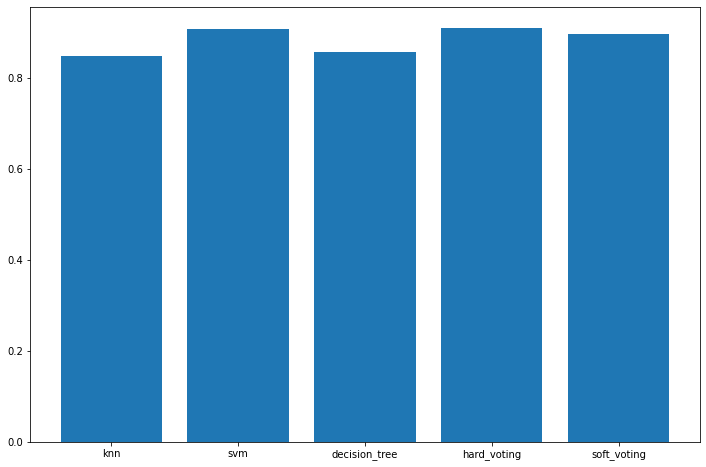

In [13]:
plt.figure(figsize=(12, 8))
x = np.arange(5)
plt.bar(x, height=[
    accuracy_score(y_test, knn_predict),
    accuracy_score(y_test, svm_predict),
    accuracy_score(y_test, dtree_predict),
    accuracy_score(y_test, hv_predict),
    accuracy_score(y_test, sv_predict)
])
plt.xticks(x, ['knn', 'svm', 'decision_tree', 'hard_voting', 'soft_voting'])
plt.show()